In [16]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

with nc.Dataset('/Users/mgrecu/WDomains/MCS_OK/wrfout_d03_2018-06-25_04:00:00') as f:
    rain = f.variables['RAINNC'][:]
    dbz=f.variables['REFL_10CM'][:]
    height=(f.variables['PH'][:]+f.variables['PHB'][:])/9.81
    lon=f.variables['XLONG'][:]
    lat=f.variables['XLAT'][:]
    qr=f.variables['QRAIN'][:]
    ncrain=f.variables['QNRAIN'][:]
    qgraup=f.variables['QGRAUP'][:]
    ncgraup=f.variables['QNGRAUPEL'][:]
    qsn=f.variables['QSNOW'][:]
    t=f.variables['T'][:]+300
    p=f.variables['P'][:]+f.variables['PB'][:]
    tk=t*(p/100000)**0.286
    rho=p/(287.05*tk)
    #qhail=f.variables['QHAIL'][:]
    #ncsn=f.variables['QNSNOW'][:]

(189, 201) (189, 201) (83, 189, 201)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


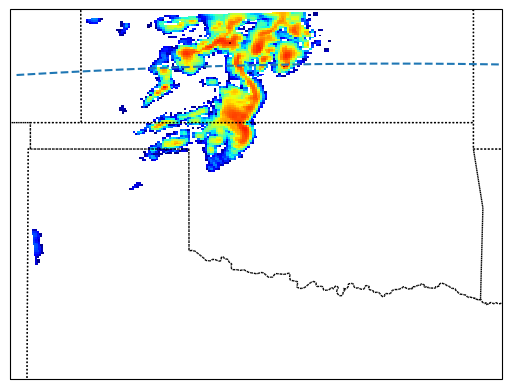

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
print(lon[0].shape, lat[0].shape, dbz[0].shape)
dbzm=np.ma.masked_where(dbz[:,:,:,:]<10, dbz[:,:,:,:])
plt.pcolormesh(lon[0,:,:], lat[0,:,:], dbzm[0,0,:,:], vmin=10, vmax=60, cmap='jet')
plt.plot(lon[0,160,:], lat[0,160,:], '--')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')


(4, 189, 201)
(4, 84, 189, 201)
(83, 201)
(201,)
(84,)


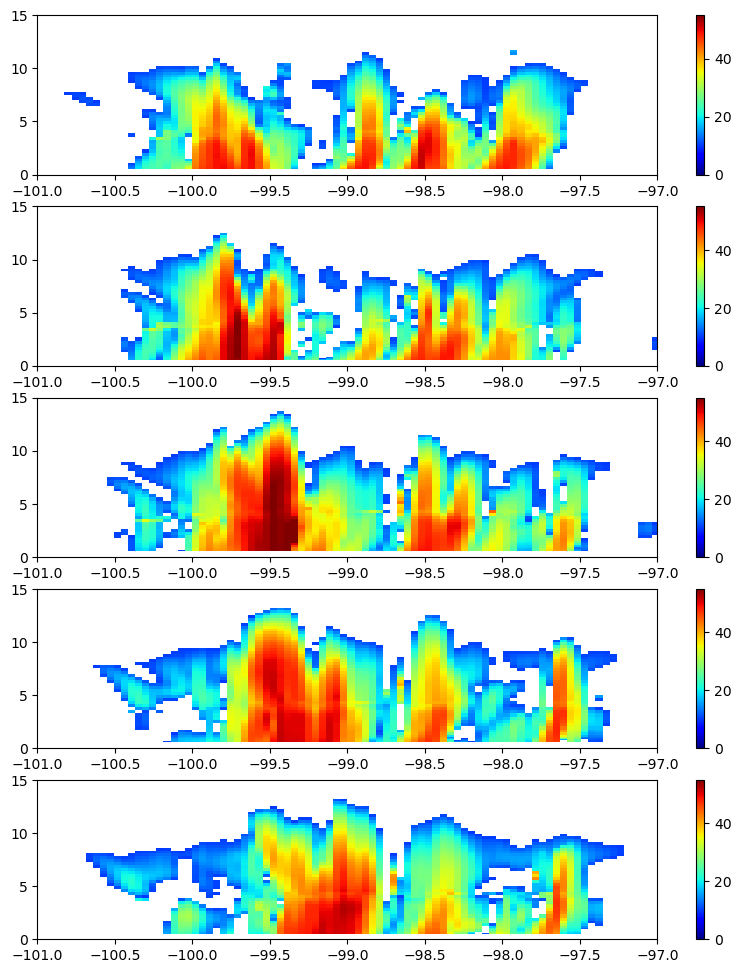

In [3]:
print(lon.shape)
print(height.shape)
print(dbzm[0,:,160,:].shape)
print(lon[0,160,:].shape)
print(height[0,:,160,100].shape)
plt.figure(figsize=(10,12))
for i in range(5,10):
    plt.subplot(5,1,i-5+1)
    plt.pcolormesh(lon[0,160,:],height[0,:-1,155+2*i,100]/1e3,dbzm[1,:,158+2*i,:], cmap='jet',vmin=0, vmax=55)
    plt.colorbar()
    plt.xlim(-101, -97)
    plt.ylim(0, 15)

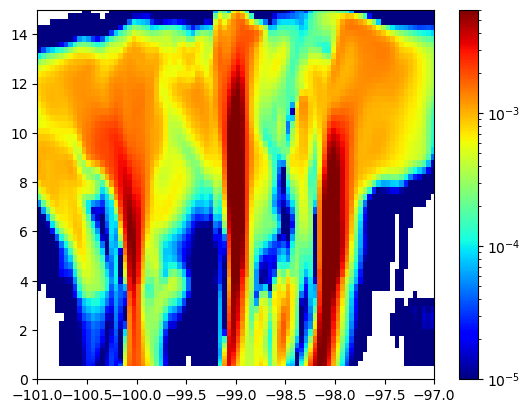

In [6]:
import lkTables
lkTables=lkTables.scattTables() 
from bisectm import bisectm
qt=qr+1*qsn+qgraup
for iy in range(5,6):
    plt.subplot(1,1,iy-5+1)
    plt.pcolormesh(lon[0,160,:],height[0,:-1,155+2*iy,100]/1e3,qt[0,:,155+2*iy,:], cmap='jet',norm=colors.LogNorm(vmin=1e-5, vmax=6e-3))
    plt.colorbar()
    plt.xlim(-101, -97)
    plt.ylim(0, 15)

88


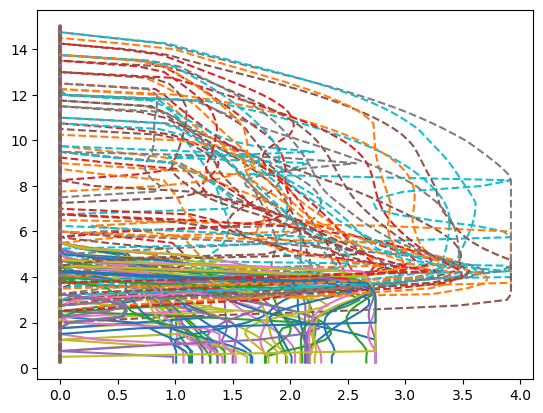

In [28]:
hint=0.25+np.arange(0,60)*0.25
iscene=0
rhow=1000
rhos=100
rhog=400
dmg=np.zeros(qgraup.shape)
dmr=np.zeros(qgraup.shape)
a1=np.nonzero(qgraup>1e-5)
dmg[a1]=4/(ncgraup[a1]*3.1415*rhog/qgraup[a1])**0.333*1e3
a1=np.nonzero(qr>1e-5)
dmr[a1]=4/(ncrain[a1]*3.1415*rhow/qr[a1])**0.333*1e3
dmr[dmr>3]=3
dmg[dmg>3.92]=3.92
for iy in range(5,6):
    a=np.nonzero((lon[0,160,:]+101)*(lon[0,160,:]+97)<0)
    print(len(a[0]))
    zKuL=[]
    for i in a[0]:
        h1=(height[iscene,:-1,155+2*iy,i]+height[iscene,1:,155+2*iy,i])/2e3
        swc1=np.interp(hint, h1, qsn[iscene,:,155+2*iy,i]*rho[iscene,:,155+2*iy,i]*1e3)
        rwc1=np.interp(hint, h1, qr[iscene,:,155+2*iy,i]*rho[iscene,:,155+2*iy,i]*1e3)
        gwc1=np.interp(hint, h1, qgraup[iscene,:,155+2*iy,i]*rho[iscene,:,155+2*iy,i]*1e3)
        nr1=np.interp(hint, h1, ncrain[iscene,:,155+2*iy,i])
        ng1=np.interp(hint, h1, ncgraup[iscene,:,155+2*iy,i])
        dmr1=np.interp(hint, h1, dmr[iscene,:,155+2*iy,i])
        dmg1=np.interp(hint, h1, dmg[iscene,:,155+2*iy,i])
        #plt.plot(dmr1, hint, '-')
        #plt.plot(dmg1, hint, '--')
            n1=gwc.shape[0]
         
        
   

In [35]:
def getZku(gwc,swc,rwc,dmr,dmg,dr):
    n1=gwc.shape[0]
    piaKu=0
    piaKa=0
    zKuSim=np.zeros((n1),float)-99
    zKu_true=np.zeros((n1),float)-99
    zKaSim=np.zeros((n1),float)-99
    zKa_true=np.zeros((n1),float)-99
    kexttot=np.zeros((n1),float)
    salbtot=np.zeros((n1),float)
    asymtot=np.zeros((n1),float)
    
    nfreqm=8
    kext1D=np.zeros((n1,nfreqm),float)
    salb1D=np.zeros((n1,nfreqm),float)
    asym1D=np.zeros((n1,nfreqm),float)
    for k1 in range(n1-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dns=0
        dng=0
        dmg[k1]=max(lkTables.dmg[0],dmg[k1])
        dmg[k1]=min(dmg[k1],lkTables.dmg[-1])
        dmr[k1]=max(lkTables.dmr[0],dmr[k1])
        dmr[k1]=min(dmr[k1],lkTables.dmr[-1])
        if gwc[k1]>0.01:
            ind=bisectm(lkTables.dmg.data,272,dmg[k1])
            dng=np.log10(gwc[k1]/lkTables.gwc.data[ind])
            zKug=lkTables.zKuG[ind]+10*dng
            zKag=lkTables.zKaG[ind]+10*dng
            attKug=lkTables.attKuG[ind]*10**dng
            attKag=lkTables.attKaG[ind]*10**dng
            attKu+=attKug
            attKa+=attKag
            zku+=10**(0.1*zKug)
            zka+=10**(0.1*zKag)
            kext1D[k1,:]+=lkTables.kextG[ind,:]*10**dng
            salb1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]
            asym1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]*lkTables.asymG[ind,:]
        if swc[k1]>0.01:
            ind=bisectm(lkTables.swc.data,253,swc[k1])
            dns=0
            zKus=lkTables.zKuS[ind]+10*dns
            zKas=lkTables.zKaS[ind]+10*dns
            attKus=lkTables.attKuS[ind]*10**dns
            attKas=lkTables.attKaS[ind]*10**dns
            attKu+=attKus
            attKa+=attKas
            zku+=10**(0.1*zKus)
            zka+=10**(0.1*zKas)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dns
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        if rwc[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmr[k1])
            dnr=np.log10(rwc[k1]/lkTables.rwc.data[ind])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    return zKuSim, zKaSim, zKu_true, zKa_true, kext1D, salb1D, asym1D

In [37]:
#print(swc1, rwc1, gwc1, dmg1, dmr1)
zKuSim, zKaSim, zKu_true, zKa_true, kext1D, salb1D, asym1D=getZku(gwc1,swc1,rwc1,dmr1,dmg1,0.25)
print(zKuSim)

[-99.         -99.         -99.         -99.         -99.
 -99.         -99.         -99.           8.01644134   9.01863776
   8.52840004 -99.         -99.         -99.         -99.
 -99.         -99.         -99.         -99.         -99.
 -99.         -99.         -99.         -99.         -99.
 -99.         -99.         -99.         -99.         -99.
 -99.         -99.         -99.         -99.         -99.
   4.24738182   9.99740097  12.99744213  13.99750181  14.24756954
  14.49764094  14.49771422  14.74778951  15.49787353  16.74797832
  18.24812025  19.24830572  19.74852382  19.99876073  19.99900429
  19.49923493  19.24944676  18.74964189  17.49980403  14.99991478
  10.74997234   4.99999457 -99.         -99.         -99.        ]
